# CSX46 Class Notebook 2 - Data Structures


## Part 1: Comparing running times for neighbor enumeration

In this notebook we will measure the running time for enumerating the neighbor vertices for three different data structures for representing an undirected graph:
- adjacency matrix
- adjacency list
- edge list

Let's assume that each vertex is labeled with a unique integer number.  So if there are *N* vertices, the vertices are labeled 0, 2, 3, 4, ..., *N*-1.

First, we will import all of the Python modules that we will need for this exercise:
note how we assign a short name, "np" to the numpy module. This will save typing.

Import the builtin python modules that we will need in Part 1:

In [ ]:
import numpy as np
import timeit

Install pycairo so that we can plot in igraph

In [ ]:
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
import cairo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
libgif-dev is already the newest version (5.1.9-2build2).
libjpeg-dev is already the newest version (8c-2ubuntu10).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


Install `python-igraph` and import it (see [Class Session 1 notebook](https://colab.research.google.com/drive/1LbdlGfkqmr726UpUqPP9_z2pBIVm200n?usp=sharing) for details):

In [ ]:
!pip install python-igraph
import igraph

Now, define a function that returns the index numbers of the neighbors of a vertex `i`, when the
graph is stored in adjacency matrix format.  So your function will accept as an input a *N*⨉*N* numpy matrix. The function should return a list (of index numbers of the neighbors).

In [ ]:
def enumerate_matrix(gmat, i):
    gmat_row = gmat[i, :]
    indices_of_nonzero_columns = np.nonzero(gmat_row)[1]
    return indices_of_nonzero_columns.tolist()

In [ ]:
import numpy as np
enumerate_matrix(np.matrix([[0,1],[1,0]]), 0)

[1]

Define a function that enumerates the neighbors of a vertex i, when the
graph is stored in adjacency list format (a list of lists). The function should return a list (of index numbers of the neighbors).

In [ ]:
def enumerate_adj_list(adj_list, i):
    return adj_list[i]

Define a function that enumerates the neighbors of a vertex i, when the
graph is stored in edge-list format (a numpy array of length-two-lists); use `numpy.where` and `numpy.unique`. The function should return a list (of index numbers of the neighbors).

In [ ]:
def enumerate_edge_list(edge_list, i):
    inds1 = np.where(edge_list[:,0] == i)[0]
    elems1 = edge_list[inds1, 1].tolist()
    inds2 = np.where(edge_list[:,1] == i)[0]
    elems2 = edge_list[inds2, 0].tolist()
    return np.unique(elems1 + elems2).tolist()

In this notebook, we are going to create some random networks. We'll use the Barabasi-Albert method, which has two parameters, *n* and *m* (where *n* > *m*). (For more information on the Barabasi-Albert model, see http://barabasi.com/f/622.pdf). In `igraph`, the `igraph.Graph.Barabasi` method will generate a single connected undirected graph with *n* vertices and where the total number *E* of edges is:

    E = nm - (m^2 / 2) - m/2
    
Let's plot a Barabasi-Albert graph generated using *n*=5 and *m*=3:

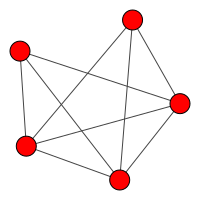

In [ ]:
igraph.drawing.plot(igraph.Graph.Barabasi(5,3), bbox=[0,0,200,200])

Now we need to write a simulation funtion that generates random graphs and enumerates all neighbors of each vertex in the graph (while computing running time), for each of three different graph data structures (adjacency matrix, adjacency list, and edge list). The function's sole argument "n" is the number of vertices.
It returns a length-three list containing the average running time for enumerating the neighbor vertices of a vertex in the graph.

In [ ]:
def do_sim_ms(n):

    retlist = []

    nrep = 10
    nsubrep = 10

    # this is (sort of) a Python way of doing the R function "replicate":
    for _ in range(nrep):

        # make a random undirected graph with fixed (average) vertex degree = 5
        g = igraph.Graph.Barabasi(n, 5)

        # get the graph in three different representations
        g_matrix = np.matrix(g.get_adjacency().data)
        g_adj_list = g.get_adjlist()
        g_edge_list = np.array(g.get_edgelist())

        start_time = timeit.default_timer()

        for _ in range(nsubrep):
            for i in range(0, n):
                enumerate_matrix(g_matrix, i)

        matrix_elapsed = timeit.default_timer() - start_time

        start_time = timeit.default_timer()

        for _ in range(nsubrep):
             for i in range(0, n):
                enumerate_adj_list(g_adj_list, i)

        adjlist_elapsed = timeit.default_timer() - start_time

        start_time = timeit.default_timer()

        for _ in range(nsubrep):
             for i in range(0, n):
                enumerate_edge_list(g_edge_list, i)

        edgelist_elapsed = timeit.default_timer() - start_time

        retlist.append([matrix_elapsed, adjlist_elapsed, edgelist_elapsed])

        resarray = 1000.0 * np.mean(np.array(retlist), axis=0)/n

        resdict = {'adjacency matrix': resarray[0],
                   'adjacency list': resarray[1],
                   'edge list': resarray[2]}
        # average over replicates and then
        # divide by n so that the running time results are on a per-vertex basis
    return resdict

A simulation with 1000 vertices clearly shows that adjacency list is fastest:

In [ ]:
do_sim_ms(1000)

{'adjacency matrix': 0.2123166105000564,
 'adjacency list': 0.00332407060004698,
 'edge list': 0.73447486390005}

Now let's double "n". We see the expected behavior, with the running time for the adjacency-matrix and edge-list formats going up when we increase "n", but there is hardly any change in the running time for the graph stored in adjacency list format:

In [ ]:
do_sim_ms(2000)

{'adjacency matrix': 0.2715418965000481,
 'adjacency list': 0.0018779323499757083,
 'edge list': 0.6608220061499879}

## Part 2: Comparing running times for the "find" operation (introducing "adjacency forests")

## Exploring the average running time for testing if there is an edge between an arbitrary pair of vertices, for different graph data structures

In this exercise, we'll compare the asymptotic computational running time for testing if there is an edge between a pair of vertices, averaged over all pairs of vertices in the graph. We'll do it for a series of undirected graphs (each generated using an Barabasi-Albert model), each with 1000 vertices. We will vary the number of edges in the graph; each graph will have a different average number of vertex neighbors for a vertex (i.e., each graph will have a different average vertex degree). We will time how long it takes to test all possible pairs of vertices for whether or not there is an edge between them, for each of four different graph data structures (adjacency matrix, adjacency list, edge list, and adjacency forest).

We'll need the "bintrees" python module in order to get an implementation of a binary search tree (AVLTree is the class that we will use).

In [ ]:
!pip install --only-binary=:all: bintrees
import bintrees

Now we will need to define some functions for testing a pair of vertices to see if they have an edge between them, for each of three different kinds of data structures for representing the graph.

First, we need to create a function, `find_matrix`, that accepts an adjacency matrix (`np.matrix`) `gmat` and a row index `i` and a column index `j`, and returns `True` if there is an edge between vertices `i` and `j` (or `False` otherwise). You'll probably want to use array indexing here.

In [ ]:
def find_matrix(gmat, i, j):
    return (gmat[i,j] == 1)

Next, we need to create a function, `find_adj_list`, that accepts an adjacency list `adj_list` (which is actually a list of lists of integer vertex IDs). Your function should return `True` if there is an edge between vertex `i` and vertex `j`, or `False` otherwise). You may wisth to use the built-in keyword `in`.

In [ ]:
def find_adj_list(adj_list, i, j):
    return j in adj_list[i]

Next, we need to create a function, `find_edge_list`, that accepts an edge list argument `edge_list` (which is actually a `numpy.array` of lists (each of length two) containing the vertex IDs of vertices that are connected in the graph). Your function should return `True` if there is an edge between vertex `i` and vertex `j`, or `False` otherwise). You will want to use the functions `numpy.where`, `tolist`, and the keyword `in`.

In [ ]:
def find_edge_list(edge_list, i, j):
    return (([i,j] in edge_list) or ([j,i] in edge_list))

Next we need to create a function, `find_bst_forest`, that accepts an "adjacency forest" argument `bst_forest` (which is actually a list of objects of class `bintrees.AVLTree`). Your function should return `True` if there is an edge between vertex `i` and vertex `j`, or `False` otherwise). You'll want to use the class method `__contains__(j)`.

In [ ]:
def find_bst_forest(bst_forest, i, j):
    return bst_forest[i].__contains__(j)

Next, we will need a function, `get_bst_forest`, that can create an adjacency forest representation for a graph given an adjacency list as input.  *Important NOTE:* I have deleted the code to create the AVL tree. You should add it.

In [ ]:
def get_bst_forest(theadjlist):
    g_adj_list = theadjlist
    n = len(g_adj_list)
    theforest = []
    for i in range(0,n):
        itree = bintrees.AVLTree()
        for j in g_adj_list[i]:
            itree.insert(j,1)
        theforest.append(itree)
    return theforest

Here is the code to run the simulation (generate the graph and obtain timing statistics). To keep the code running time reasonable, I decided to only compare the running times for the "adjacency list" and "adjacency forest" (aka "adjacency trees") graph data structures.  The parameter "n" is the number of vertices (fixed at 1000) and the parameter "k" is the average vertex degree (which we will vary in this exercise). For speed, I have turned off replication (by setting nrep=1 and nsubrep=1), but you can try it with larger values of nrep to see if the results hold up (I expect they will):

In [ ]:
def do_sim(n, k):

    retlist = []

    nrep = 1
    nsubrep = 1

    for _ in range(nrep):

        # make the random undirected graph
        g = igraph.Graph.Barabasi(n, k)

        # get the graph in three different representations
        g_matrix = np.matrix(g.get_adjacency().data)

        g_adj_list = g.get_adjlist()

        g_bst_forest = get_bst_forest(g_adj_list)

        start_time = timeit.default_timer()

        # inner loop only needs to go from i+1 to n, since the graph is undirected
        for _ in range(nsubrep):
            for i in range(0, n):
                for j in range(i+1, n):
                    find_matrix(g_matrix, i, j)

        matrix_elapsed = timeit.default_timer() - start_time

        start_time = timeit.default_timer()

        # inner loop only needs to go from i+1 to n, since the graph is undirected
        for _ in range(nsubrep):
            for i in range(0, n):
                for j in range(i+1, n):
                    find_adj_list(g_adj_list, i, j)

        adjlist_elapsed = timeit.default_timer() - start_time

        start_time = timeit.default_timer()

        # inner loop only needs to go from i+1 to n, since the graph is undirected
        for _ in range(nsubrep):
            for i in range(0, n):
                for j in range(i+1, n):
                    j in g_bst_forest[i]

        forest_elapsed = timeit.default_timer() - start_time

        retlist.append([matrix_elapsed, adjlist_elapsed, forest_elapsed])

        # get the results in seconds, and make sure to divide by number of vertex pairs
    return 1000000*np.mean(np.array(retlist), axis=0)/(n*(n-1)/2)

Compare the results for differing average degree (i.e., *k*) values.  At *k*=50, the "adjacency forest" method (aka "adjacency tree" method) is a bit faster than the adjacency list method. By *k*=100, the "adjacency forest" method is faster than the "adjacency list" method.

In [ ]:
do_sim(1000, 5)

array([0.81686048, 0.4629416 , 2.35956966])

In [ ]:
do_sim(1000, 10)

array([2.01887787, 0.86707847, 1.33426014])

In [ ]:
do_sim(1000, 20)

array([1.79578281, 1.68302289, 2.67549269])

In [ ]:
do_sim(1000, 50)

array([0.80561723, 1.35629128, 1.38673102])

In [ ]:
do_sim(1000, 100)

array([0.78539225, 2.34502339, 2.02958482])